# Project 4 - 네이버 영화리뷰 감성분석 도전하기

In [1]:
import gensim
import os

from konlpy.tag import Mecab
from collections import Counter

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### (1) 데이터 준비 및 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt') # 150000 데이터
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt') # 50000 데이터

train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### (2) 데이터로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

encode, decode 함수를 구현한다.

In [4]:
# 영단어로 이루어진 벡터 -> 숫자 벡터로 encode
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_word_vec(word_vec, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in word_vec]

# 여러 문장 한꺼번에 encode
def get_encoded_word_vecs(word_vecs, word_to_index):
    return [get_encoded_word_vec(word_vec, word_to_index) for word_vec in word_vecs]

# 숫자로 encode된 벡터 -> 영단어 벡터로 decode
# 단, [1:]를 통해 <BOS>를 제외
def get_decoded_word_vec(enc_word_vec, index_to_word):
    return [index_to_word[index] if index in index_to_word else '<UNK>' for index in enc_word_vec[1:]]

# 여러 문장 한꺼번에 decode
def get_decoded_word_vecs(enc_word_vecs, index_to_word):
    return [get_decoded_word_vec(enc_word_vec, index_to_word) for enc_word_vec in enc_word_vecs]

data load 함수를 구현한다.

In [5]:
def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        # 문장을 형태소로 분리하고 stopwords에 없는 단어들만 추가
        token_X = tokenizer.morphs(sentence)
        X_train.append([word for word in token_X if not word in stopwords])

    X_test = []
    for sentence in test_data['document']:
        # 문장을 형태소로 분리하고 stopwords에 없는 단어들만 추가
        token_X = tokenizer.morphs(sentence)
        X_test.append([word for word in token_X if not word in stopwords])
    
    # 가장 빈도수가 높은 10000개 단어 선택
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)

    # 단어 사전 구성
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    index_to_word = {index : word for index, word in enumerate(vocab)}
    word_to_index = {word : index for index, word in enumerate(vocab)}

    X_train = get_encoded_word_vecs(X_train, word_to_index)
    X_test = get_encoded_word_vecs(X_test, word_to_index)
    y_train = list(train_data['label'])
    y_test = list(test_data['label'])
    
    return X_train, np.array(y_train), X_test, np.array(y_test), index_to_word, word_to_index

In [6]:
X_train, y_train, X_test, y_test, index_to_word, word_to_index = load_data(train_data, test_data, num_words)

### (3) 모델 구성을 위한 데이터 분석 및 가공

In [7]:
# 텍스트데이터 문장길이 리스트 생성
num_tokens = [len(tokens) for tokens in (X_train + X_test)]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

# 최대 길이는 (평균 + 2*표준편차)로 설정
maxlen = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
print('maxlen :', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < maxlen) / len(num_tokens) * 100 : .1f}%가 maxlen 설정값 이내에 포함')

문장길이 평균 : 16.96940191154864
문장길이 최대 : 117
문장길이 표준편차 : 12.843571191092
maxlen : 42
전체 문장의  93.1%가 maxlen 설정값 이내에 포함


In [8]:
# 최대 문장을 기준으로 padding 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(146182, 42) (146182,) (49157, 42) (49157,)


### (4) 모델 구성 및 validation set 구성

In [10]:
word_vector_dim = 16 # 워드 벡터의 차원 수

cnn_16 = tf.keras.Sequential(name='cnn_16')
cnn_16.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
cnn_16.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_16.add(tf.keras.layers.MaxPooling1D(5))
cnn_16.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_16.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_16.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_16.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

cnn_16.summary()

Model: "cnn_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9    

In [11]:
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

cnn_32 = tf.keras.Sequential(name='cnn_32')
cnn_32.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
cnn_32.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
cnn_32.add(tf.keras.layers.MaxPooling1D(5))
cnn_32.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_32.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_32.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_32.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

cnn_32.summary()

Model: "cnn_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          3600      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9    

In [12]:
word_vector_dim = 16 # 워드 벡터의 차원 수

lstm = tf.keras.Sequential(name='lstm')
lstm.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
lstm.add(tf.keras.layers.LSTM(16))
lstm.add(tf.keras.layers.Dense(8, activation='relu'))
lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

lstm.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [13]:
word_vector_dim = 16 # 워드 벡터의 차원 수

gmp = tf.keras.Sequential(name='gmp')
gmp.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
gmp.add(tf.keras.layers.GlobalMaxPooling1D())
gmp.add(tf.keras.layers.Dense(8, activation='relu'))
gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp.summary()

Model: "gmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [14]:
models = [cnn_16, cnn_32, lstm, gmp]

### (5) 모델 훈련

In [15]:
# validation set 분리
val_num = 50000
X_val = X_train[:val_num]
y_val = y_train[:val_num]

# validation set을 제외한 나머지
par_X_train = X_train[val_num:]  
par_y_train = y_train[val_num:]

history_dist = {}

vec dim 16 CNN, vec dim 32 CNN, LSTM, GlobalMaxPooling 이렇게 4가지 모델을 학습해본다.

In [16]:
for model in models:
    print(model.name, "train start")
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=10 

    history = model.fit(par_X_train,
                        np.array(par_y_train),
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)

    history_dist[model.name] = history.history
    print()

cnn_16 train start
Epoch 1/10
188/188 [==============================] - 5s 8ms/step - loss: 0.5644 - accuracy: 0.6817 - val_loss: 0.3819 - val_accuracy: 0.8283
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3509 - accuracy: 0.8470 - val_loss: 0.3580 - val_accuracy: 0.8403
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3073 - accuracy: 0.8699 - val_loss: 0.3583 - val_accuracy: 0.8420
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2763 - accuracy: 0.8854 - val_loss: 0.3660 - val_accuracy: 0.8408
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2445 - accuracy: 0.9010 - val_loss: 0.3827 - val_accuracy: 0.8366
Epoch 6/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2124 - accuracy: 0.9166 - val_loss: 0.4062 - val_accuracy: 0.8364
Epoch 7/10
188/188 [==============================] - 1s 6ms/step - loss: 0.1796 - accuracy: 0.9324 - val_loss: 0.4444 - val_accu

### (6) Loss, Accuracy 그래프 시각화

In [17]:
for model in models:
    print(model.name, "result")
    print(model.evaluate(X_test, y_test, verbose=2))
    print()

cnn_16 result
1537/1537 - 3s - loss: 0.5943 - accuracy: 0.8191
[0.5942518711090088, 0.8190898299217224]

cnn_32 result
1537/1537 - 3s - loss: 0.6602 - accuracy: 0.8172
[0.6602016091346741, 0.8172183036804199]

lstm result
1537/1537 - 3s - loss: 0.3909 - accuracy: 0.8386
[0.39093881845474243, 0.8385580778121948]

gmp result
1537/1537 - 2s - loss: 0.4123 - accuracy: 0.8344
[0.412265807390213, 0.8343877792358398]



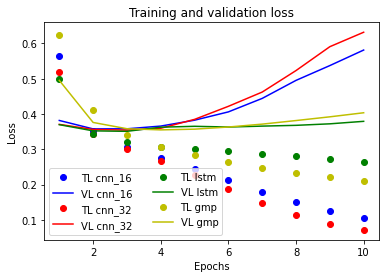

In [18]:
color = ['b', 'r', 'g', 'y']
num = 0

for model, history in history_dist.items():
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, color[num]+'o', label='TL '+model)
    plt.plot(epochs, val_loss, color[num], label='VL '+model)
    
    num += 1
    
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(ncol=2)

plt.show()

CNN들은 training loss가 낮지만, epoch가 늘어날수록 validation loss가 크게 증가하였다.  
LSTM, GMP는 training loss가 높지만, epoch가 늘어나도 validation loss가 크게 증가하진 않았다.

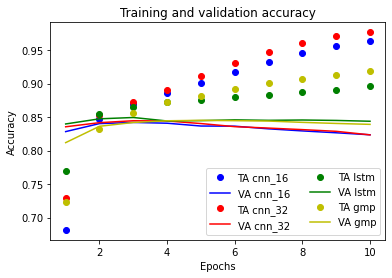

In [19]:
num = 0

for model, history in history_dist.items():
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, color[num]+'o', label='TA '+model)
    plt.plot(epochs, val_acc, color[num], label='VA '+model)
    
    num += 1
    
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(ncol=2)

plt.show()

CNN들은 training accuracy가 높았지만, epoch이 늘어날수록 validation accuracy가 점점 낮아졌다.  
LSTM, GMP는 training accuracy는 다소 낮았지만, epoch이 늘어날수록 validation accuracy가 낮아지진 않았다.

### (7) 학습된 Embedding layer 분석

In [20]:
word2vec_file_paths = []

for model in models: # 학습한 Embedding 파라미터를 파일에 저장
    word2vec_file_path = './data/word2vec_{}.txt'.format(model.name)
    word2vec_file_paths.append(word2vec_file_path)
    
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(num_words - 4, model.layers[0].output_dim)) # title

    vectors = model.get_weights()[0]
    for i in range(4, num_words):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

for word2vec_file_path in word2vec_file_paths:
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    print(word_vectors.similar_by_word("영화"))

[('무서웠', 0.7906397581100464), ('미드', 0.7865535020828247), ('외롭', 0.736176609992981), ('엉', 0.7345657348632812), ('한없이', 0.731546938419342), ('볼까', 0.7113322615623474), ('ㅣ', 0.7049014568328857), ('한번', 0.6985402703285217), ('파탄', 0.6983817219734192), ('들어오', 0.696330189704895)]
[('연결', 0.627652108669281), ('내게', 0.5870734453201294), ('복잡', 0.5868930816650391), ('지효', 0.5737143158912659), ('습', 0.5455553531646729), ('다룬', 0.5431646704673767), ('중점', 0.5384677052497864), ('선배', 0.533012330532074), ('이걸로', 0.5251250267028809), ('드라', 0.5223225355148315)]
[('멜', 0.8282473683357239), ('편성', 0.7847239971160889), ('달인', 0.7687711715698242), ('점줄', 0.7684017419815063), ('연말', 0.7640092372894287), ('쿠', 0.7356906533241272), ('케빈', 0.7091132998466492), ('관통', 0.7076927423477173), ('류승범', 0.707446813583374), ('ㅡㅡㅋ', 0.7024317383766174)]
[('음', 0.992438018321991), ('너무', 0.9911234378814697), ('을', 0.9879825115203857), ('나', 0.9823884963989258), ('하', 0.9810553193092346), ('해', 0.9796835780143738),

Embedding이 썩 잘 된 것 같지는 않다.

### (8) 한국어 Word2Vec Embedding 활용하여 성능 개선

In [22]:
word2vec_path = './data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)

In [23]:
word2vec.wv['영화'].shape # 100 dim

(100,)

In [24]:
word2vec.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [25]:
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(num_words, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, num_words):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

가장 성능이 좋았던 LSTM을 가지고 Embedding Matrix를 이용해 다시 학습한다.

In [36]:
from tensorflow.keras.initializers import Constant

kor_lstm = tf.keras.Sequential(name='kor_lstm')
kor_lstm.add(tf.keras.layers.Embedding(num_words,
                                       word_vector_dim,
                                       embeddings_initializer=Constant(embedding_matrix), # 카피한 임베딩 활용
                                       trainable=True,
                                       input_shape=(None,)))
kor_lstm.add(tf.keras.layers.LSTM(100))
kor_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
kor_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

kor_lstm.summary()

Model: "kor_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,081,217
Trainable params: 1,081,217
Non-trainable params: 0
_________________________________________________________________


In [37]:
# 학습의 진행
kor_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = kor_lstm.fit(par_X_train,
                    par_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

history_dist[kor_lstm.name] = history.history

Epoch 1/10
188/188 [==============================] - 4s 15ms/step - loss: 0.4982 - accuracy: 0.7526 - val_loss: 0.4140 - val_accuracy: 0.8120
Epoch 2/10
188/188 [==============================] - 2s 11ms/step - loss: 0.3747 - accuracy: 0.8330 - val_loss: 0.3689 - val_accuracy: 0.8363
Epoch 3/10
188/188 [==============================] - 2s 11ms/step - loss: 0.3248 - accuracy: 0.8595 - val_loss: 0.3531 - val_accuracy: 0.8430
Epoch 4/10
188/188 [==============================] - 2s 11ms/step - loss: 0.2886 - accuracy: 0.8779 - val_loss: 0.3415 - val_accuracy: 0.8526
Epoch 5/10
188/188 [==============================] - 2s 11ms/step - loss: 0.2627 - accuracy: 0.8895 - val_loss: 0.3366 - val_accuracy: 0.8574
Epoch 6/10
188/188 [==============================] - 2s 11ms/step - loss: 0.2403 - accuracy: 0.9014 - val_loss: 0.3410 - val_accuracy: 0.8580
Epoch 7/10
188/188 [==============================] - 2s 11ms/step - loss: 0.2189 - accuracy: 0.9122 - val_loss: 0.3459 - val_accuracy: 0.8578

validation accuracy가 꽤 잘 나온 것 같다.  
기존 LSTM과 비교해보자.

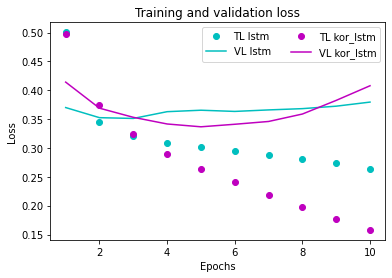

In [38]:
color = ['c', 'm']
num = 0

for model, history in history_dist.items():
    if 'lstm' in model:
        loss = history['loss']
        val_loss = history['val_loss']

        epochs = range(1, len(loss) + 1)

        plt.plot(epochs, loss, color[num]+'o', label='TL '+model)
        plt.plot(epochs, val_loss, color[num], label='VL '+model)

        num += 1
    
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(ncol=2)

plt.show()

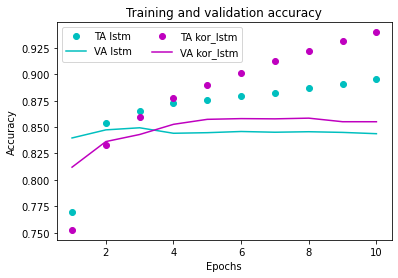

In [39]:
num = 0

for model, history in history_dist.items():
    if 'lstm' in model:
        acc = history['accuracy']
        val_acc = history['val_accuracy']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color[num]+'o', label='TA '+model)
        plt.plot(epochs, val_acc, color[num], label='VA '+model)

        num += 1
    
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(ncol=2)

plt.show()

기존 LSTM보다 accuracy가 더 높게 나왔다.  
처음 몇 epoch에서는 기존보다 accuracy가 낮았지만, 4 epoch 정도 지나고부터는 역전하였다.  
이는 기존보다 학습해야할 파라미터가 많기도 하고 단어사전의 차이도 있어서 생기는 현상이라고 생각한다.

In [40]:
print('lstm result')
print(lstm.evaluate(X_test, y_test, verbose=2))
print()
print('kor_lstm result')
print(kor_lstm.evaluate(X_test, y_test, verbose=2))

lstm result
1537/1537 - 3s - loss: 0.3909 - accuracy: 0.8386
[0.39093881845474243, 0.8385580778121948]

kor_lstm result
1537/1537 - 3s - loss: 0.4144 - accuracy: 0.8517
[0.4144410192966461, 0.8517403602600098]


최종 test accuracy는 0.85를 넘긴 것을 확인할 수 있었다.